In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()  

In [2]:
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight       

In [3]:
data_dir = 'HAM10000data'

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# For unbalanced dataset we create a weighted sampler  
dataset_train = datasets.ImageFolder(os.path.join(data_dir, 'train')) 
weights = make_weights_for_balanced_classes(dataset_train.imgs, len(dataset_train.classes))                                                                
weights = torch.DoubleTensor(weights)                                       
sampler_train = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)) 
# For unbalanced dataset we create a weighted sampler 
dataset_validation = datasets.ImageFolder(os.path.join(data_dir, 'validation')) 
weights1 = make_weights_for_balanced_classes(dataset_validation.imgs, len(dataset_validation.classes))                                                                
weights1 = torch.DoubleTensor(weights1)                                       
sampler_validation = torch.utils.data.sampler.WeightedRandomSampler(weights1, len(weights1))                     
                                                                                
sampler = {
    'train': sampler_train,
    'validation': sampler_validation,
}  


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24,
                                             sampler = sampler[x], num_workers=12)
              for x in ['train', 'validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device =  torch.device("cpu")

In [4]:
device

device(type='cuda', index=0)

In [5]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f04c059c2d0>,
 'validation': <torch.utils.data.dataloader.DataLoader at 0x7f04c0712110>}

In [6]:
dataset_sizes

{'train': 8011, 'validation': 2004}

In [7]:
with open('class.txt', 'w') as filehandle:
    for item in class_names:
        filehandle.write('%s\n' % item)

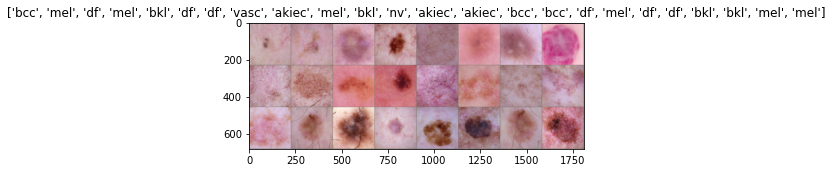

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
model_conv = torch.hub.load('rwightman/gen-efficientnet-pytorch', 'mixnet_xl', pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier.in_features
model_conv.classifier = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


Using cache found in /home/jyao/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.4955 Acc: 0.5217
validation Loss: 1.3328 Acc: 0.5753

Epoch 1/24
----------
train Loss: 1.1156 Acc: 0.6515
validation Loss: 1.1710 Acc: 0.6013

Epoch 2/24
----------
train Loss: 0.9828 Acc: 0.6823
validation Loss: 1.1126 Acc: 0.6123

Epoch 3/24
----------
train Loss: 0.9267 Acc: 0.6925
validation Loss: 1.0727 Acc: 0.6133

Epoch 4/24
----------
train Loss: 0.8826 Acc: 0.7035
validation Loss: 1.0806 Acc: 0.6083

Epoch 5/24
----------
train Loss: 0.8171 Acc: 0.7304
validation Loss: 1.0558 Acc: 0.6083

Epoch 6/24
----------
train Loss: 0.8157 Acc: 0.7238
validation Loss: 1.0248 Acc: 0.6193

Epoch 7/24
----------
train Loss: 0.7937 Acc: 0.7296
validation Loss: 1.0351 Acc: 0.6243

Epoch 8/24
----------
train Loss: 0.7933 Acc: 0.7334
validation Loss: 1.0123 Acc: 0.6577

Epoch 9/24
----------
train Loss: 0.8044 Acc: 0.7224
validation Loss: 0.9886 Acc: 0.6532

Epoch 10/24
----------
train Loss: 0.7860 Acc: 0.7382
validation Loss: 1.0150 Acc: 0.6467

Epoch 11/

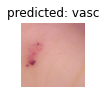

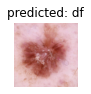

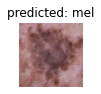

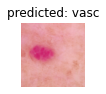

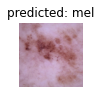

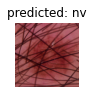

In [13]:
visualize_model(model_conv)

In [14]:
torch.save(model_conv, "model_conv_mixnet_xl.pth")

In [15]:
class_list = []
pred_list = []
prob_list = np.empty((0,7), float)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['validation']):
        #print(inputs)
        inputs = inputs.to(device)
        #print(classes.tolist())

        classes = classes.to(device)
        outputs = model_conv(inputs)
        #print(outputs)
        _, preds = torch.max(outputs, 1)
        prob = F.softmax(outputs, dim=1)
        #print(prob[])
        #print("next")
        class_list = class_list + classes.tolist()
        pred_list = pred_list + preds.cpu().tolist()
        #prob_list = prob_list + prob.cpu().tolist()
        prob_list = np.append(prob_list, prob.cpu().numpy(), axis=0)
        


In [16]:
from sklearn.metrics import roc_auc_score
roc_auc_score(class_list, prob_list, average = "weighted", multi_class = "ovr")

0.916705712377561

In [17]:
from sklearn.metrics import roc_auc_score
roc_auc_score(class_list, prob_list, average = "weighted", multi_class = "ovo")

0.9160329977925886

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(accuracy_score(class_list, pred_list))
print(precision_score(class_list, pred_list, average = "weighted"))
print(recall_score(class_list, pred_list, average = "weighted"))
print(f1_score(class_list, pred_list, average = "weighted"))



0.6631736526946108
0.6650268708303881
0.6631736526946108
0.6633264268661185


# 2 Class Statistics

In [19]:
prob_2class = prob_list[:,0]+prob_list[:,1]+prob_list[:,4]

In [20]:
class_2class = [1 if x in [0,1,4] else 0 for x in class_list]

In [21]:
pred_2class = [1 if x in [0,1,4] else 0 for x in pred_list]

In [22]:
print(accuracy_score(class_2class, pred_2class))
print(precision_score(class_2class, pred_2class))
print(recall_score(class_2class, pred_2class))
print(f1_score(class_2class, pred_2class))

0.8188622754491018
0.7834691501746216
0.7917647058823529
0.7875950848449385


In [23]:
roc_auc_score(class_2class, prob_2class)

0.9064512182689367

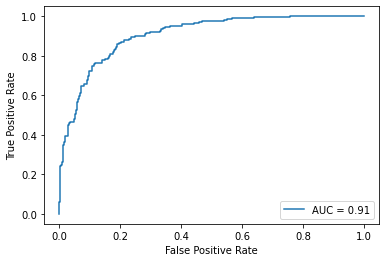

In [24]:
import matplotlib.pyplot as plt
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(class_2class, prob_2class)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot() 
plt.show()